In [ ]:
!pip install py3Dmol
!pip install rdkit
!pip install pyscf
!pip install botorch

To open on Google Colab [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week6/BayesOpt_H2O_PES.ipynb)

In [3]:
import py3Dmol
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, rdDetermineBonds, MolFromXYZBlock
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

# XYZ Rodrigo

In [5]:
def draw_with_spheres(xyz):
    raw_mol = Chem.MolFromXYZBlock(xyz)
    conn_mol = Chem.Mol(raw_mol)
    rdDetermineBonds.DetermineConnectivity(conn_mol)

    v = py3Dmol.view(width=400,height=400)
    IPythonConsole.addMolToView(conn_mol,v)
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.35},'stick':{'radius':0.1}});
    v.show()

In [ ]:
xyz = '''3
* (null), Energy   -1000.0000000
H     0.00000     0.7554     -0.47116
H     0.00000    -0.75545     -0.4711
O     0.00000     0.00000     0.11779
'''

draw_with_spheres(xyz)

In [7]:
print(type(xyz))

<class 'str'>


# Water molecule PES-SCAN

In [186]:
import numpy as np
import pyscf
from pyscf import dft

def get_xyz_matrix(angle, dist, n_atoms = 3):
    xyz = []
    
    mol = pyscf.gto.Mole()
    mol.atom = '''
      O
      H  1  	1.2
      H  1  %.3f  2 %.3f
    '''%(dist,angle)
    mol.unit = 'Angstrom'
    mol.build()
    for i in range(n_atoms):
        xyzi = mol.atom_coord(i).tolist()
        xyzi = [mol.atom_symbol(i)] + xyzi
        xyz.append(xyzi)

    xyz_str = '%s\n Generated by PySCF\n'%(n_atoms)
    for xyzi in xyz:
        print(xyzi)
        xyzi_str = '%s     %.4f     %.4f     %.4f\n'%(xyzi[0],xyzi[1],xyzi[2],xyzi[3])
        xyz_str += xyzi_str
    return xyz_str

In [131]:
def energy_water(angle,dist):
    mol = pyscf.gto.Mole()
    mol.atom = '''
      O
      H  1  	1.2
      H  1  %.3f  2 %.3f
    '''%(dist,angle)
    mol.unit = 'Angstrom'
    mol.basis = 'sto-3g' #basis set level
    mol.build()
    rks_h2o = dft.RKS(mol)
    rks_h2o.xc = 'b3lyp'
    energy =rks_h2o.kernel()

    xyz = f'3\nGenerated by PySCF\n' #+ xyz
    return energy, xyz

In [136]:
# angle_list = np.linspace(-5., 5., 10)  + 111.413 #  111.413 in radians is 1.94452367952 	#np.linspace(-0.25, 0.25, 5)
angle_list = np.linspace(20., 180., 10)
dist_list = np.linspace(0.5, 2.0, 10)
print(angle_list)
print(dist_list)

[ 20.          37.77777778  55.55555556  73.33333333  91.11111111
 108.88888889 126.66666667 144.44444444 162.22222222 180.        ]
[0.5        0.66666667 0.83333333 1.         1.16666667 1.33333333
 1.5        1.66666667 1.83333333 2.        ]


In [ ]:
xyz_all = []
pes = []

X,Y = np.meshgrid(angle_list,dist_list)
for angle,dist in zip(X.flatten(),Y.flatten()):
      # pes_i, xyz_i = scan_pes(angle,dist)
      pes_i, xyz_i = energy_water(angle,dist)
      pes.append(pes_i)
      xyz_all.append(xyz_i)

Text(0, 0.5, 'H-O Bond distance')

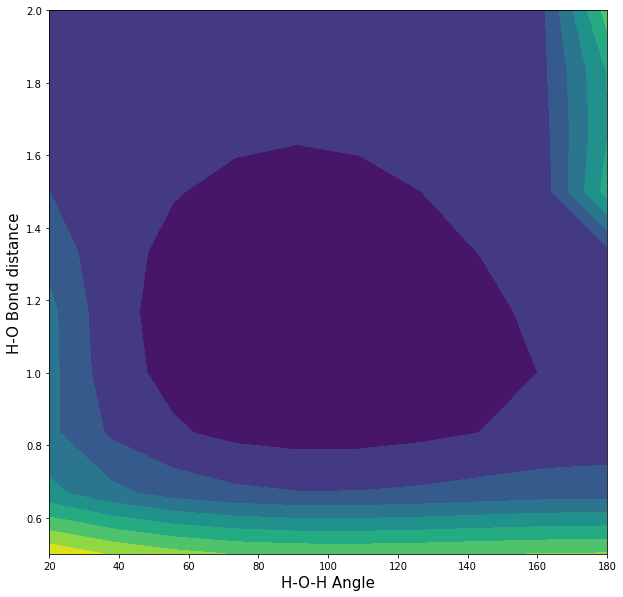

In [143]:
import matplotlib
import matplotlib.pyplot as plt

# print(pes)
# for xyzi in xyz_all:
#   print(xyzi)

D = {'Energy':np.asarray(pes),
     'X':np.column_stack((X.flatten(),Y.flatten()))}

# X,Y = np.meshgrid(angle_list,dist_list)
Z = np.asarray(pes).reshape(X.shape)

plt.figure(figsize=(10,10))
plt.contourf(X,Y,Z,levels=10)
plt.xlabel('H-O-H Angle',fontsize=15)
plt.ylabel('H-O Bond distance',fontsize=15)

## Bayesian optimization 

Tutorial based on [link](https://botorch.org/docs/getting_started)

In [199]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

In [247]:
def scale_data(y,bool_min=True):
    mu = np.mean(y)
    std = np.std(y)
    if bool_min:
      z = -1
    else:
      z = 1 

    def scale(x):
      x = (x-mu)/std
      return z*x
    return scale


In [259]:
# random initial geometries

Xtot = D['X']
ytot = D['Energy']
# ytot = -(ytot-np.mean(ytot))/np.std(ytot)

# (x-mean)/std
f_scale = scale_data(ytot)
ytot = f_scale(ytot)


Ninit = 5
i0 = np.random.randint(0,Xtot.shape[0], Ninit)
X_train = torch.tensor(Xtot[i0])
y_train = torch.tensor(ytot[i0]).unsqueeze(-1)

print(X_train.shape,y_train.shape)

torch.Size([5, 2]) torch.Size([5, 1])


In [260]:
# define a GP for Bayesian Optimization

gp = SingleTaskGP(X_train, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

In [261]:
# Construct an aquisition function

UCB = UpperConfidenceBound(gp, beta=0.1)

In [262]:
# Optimize the acquisition function

bounds = torch.tensor([[20.,0.5],[180,2.]])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
print(candidate)

tensor([[113.5937,   0.8895]])


In [265]:
candidates = []
X_train_bo = X_train
y_train_bo = y_train
for i in range(10):
    gp = SingleTaskGP(X_train_bo, y_train_bo)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);
    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    # print(candidate)
    candidates.append(candidate.detach().numpy()[0])
    

    xi = candidate.detach().numpy()[0]
    angle = xi[0]
    dist = xi[1]
    y_energy0,_ = energy_water(angle,dist)
    y_energy = f_scale(np.array([y_energy0]))

    X_train_bo = torch.vstack((X_train_bo,candidate))
    y_train_bo = torch.vstack((y_train_bo,torch.tensor([y_energy])))
    print(i,xi,y_energy0)


converged SCF energy = -75.1814838213837
0 [142.45755     0.9067815] -75.18148382138368
converged SCF energy = -75.2593947260088
1 [108.87931     1.0422096] -75.25939472600881
converged SCF energy = -75.1051266496945
2 [140.32402     1.5854553] -75.1051266496945
converged SCF energy = -75.2593957226994
3 [108.87821     1.0419021] -75.25939572269941
converged SCF energy = -75.2462611115636
4 [73.333336   1.0691408] -75.24626111156358
converged SCF energy = -75.2547543718451
5 [108.8679       0.96276635] -75.25475437184505
converged SCF energy = -74.7018299728758
6 [112.093895     0.57461363] -74.70182997287576
converged SCF energy = -75.2462611115636
7 [73.33333    1.0691395] -75.2462611115636
converged SCF energy = -75.2462611115636
8 [73.33333    1.0691433] -75.24626111156356
converged SCF energy = -75.2462611115636
9 [73.333336   1.0691402] -75.24626111156357


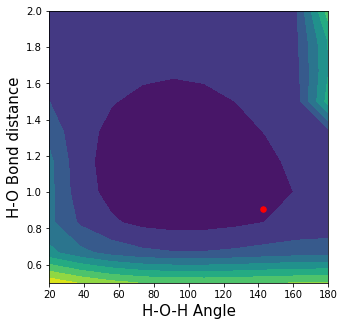

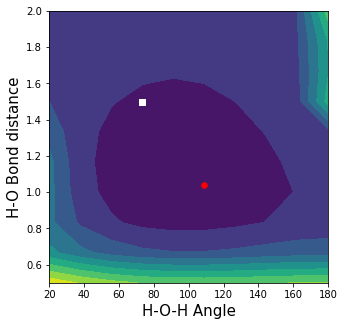

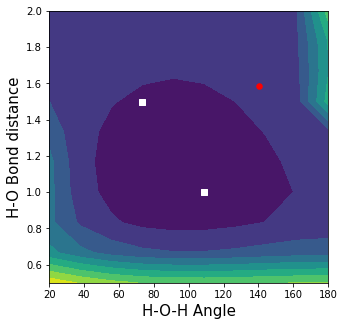

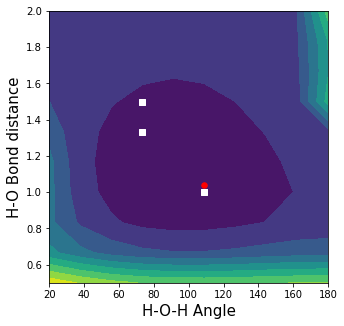

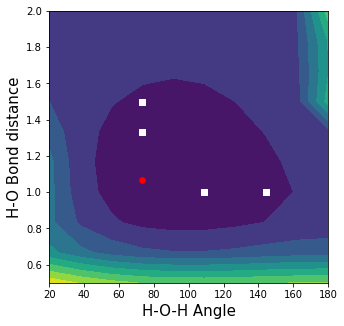

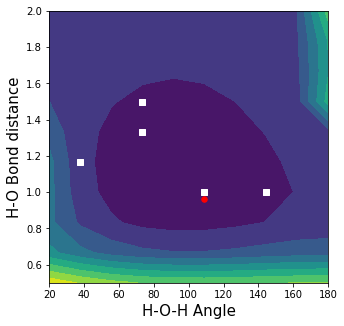

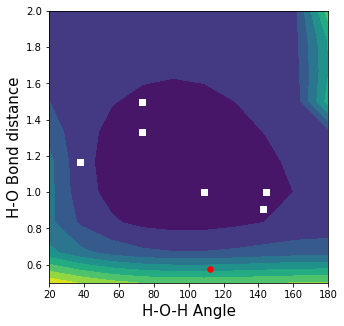

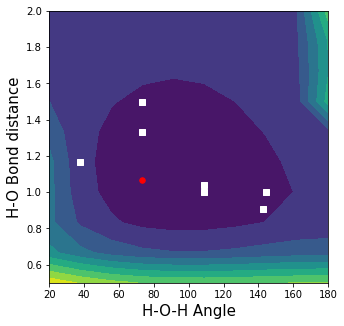

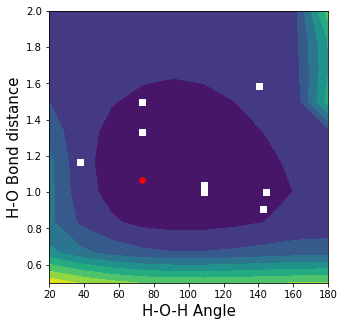

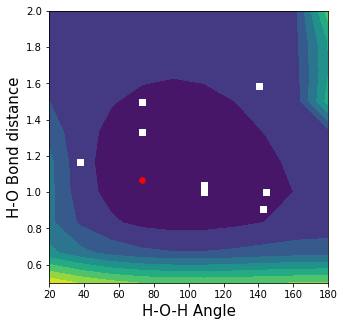

In [270]:
candidates = np.asarray(candidates)
for i,x in enumerate(candidates):
    plt.figure(figsize=(5,5))
    plt.clf()
    plt.contourf(X,Y,Z,levels=10)
    plt.scatter(X_train_bo.detach().numpy()[:i,0],X_train_bo.detach().numpy()[:i,1],color='w',s=30,marker='s')
    plt.scatter(candidates[i,0],candidates[i,1],color='r',s=30,marker='o')
    plt.xlabel('H-O-H Angle',fontsize=15)
    plt.ylabel('H-O Bond distance',fontsize=15)